<a href="https://colab.research.google.com/github/Arjavjain100/Apple-Scab-Detection/blob/main/Efficient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!git clone "https://github.com/Arjavjain100/Apple-Scab-Detection.git"

Cloning into 'Apple-Scab-Detection'...
remote: Enumerating objects: 570, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 570 (delta 26), reused 48 (delta 21), pack-reused 510
Receiving objects: 100% (570/570), 1.17 GiB | 17.58 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Checking out files: 100% (1032/1032), done.


In [3]:
# Importing required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torchvision import datasets, transforms, models
from tqdm.auto import tqdm
from torchinfo import summary
import matplotlib.pyplot as plt

In [4]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

In [5]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [6]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [7]:

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [8]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [9]:
auto_transforms = models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
batch_size = 32
# Change Tranforms accordong to the model
transform = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((227, 227)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((227, 227)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])
}
test_data = datasets.ImageFolder('/content/Apple-Scab-Detection/Augmented Dataset/Test', transform = auto_transforms)
train_data = datasets.ImageFolder('/content/Apple-Scab-Detection/Augmented Dataset/Test',  transform = auto_transforms)
train_loader = torch.utils.data.DataLoader(
    train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(
    test_data, shuffle=True, batch_size=batch_size)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Change model
model = models.efficientnet_b0(models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=2, # same number of output units as our number of classes
                    bias=True)).to(device)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [12]:
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [13]:
#Tune hyperparameters
NUM_EPOCHS = 100
criterion = nn.CrossEntropyLoss()
optimizer = opt.SGD(model.parameters(), lr =0.001, momentum = 0.9)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

pt_results = train(model=model, 
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=criterion, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7214 | train_acc: 0.3750 | test_loss: 0.6675 | test_acc: 0.6484
Epoch: 2 | train_loss: 0.6826 | train_acc: 0.6562 | test_loss: 0.6468 | test_acc: 0.7500
Epoch: 3 | train_loss: 0.5951 | train_acc: 0.7969 | test_loss: 0.5553 | test_acc: 0.7969
Epoch: 4 | train_loss: 0.5209 | train_acc: 0.7891 | test_loss: 0.5026 | test_acc: 0.7812
Epoch: 5 | train_loss: 0.4912 | train_acc: 0.8047 | test_loss: 0.4742 | test_acc: 0.7891
Epoch: 6 | train_loss: 0.4291 | train_acc: 0.7969 | test_loss: 0.4619 | test_acc: 0.7891
Epoch: 7 | train_loss: 0.4340 | train_acc: 0.7891 | test_loss: 0.6996 | test_acc: 0.5469
Epoch: 8 | train_loss: 0.8269 | train_acc: 0.5469 | test_loss: 0.4336 | test_acc: 0.7891
Epoch: 9 | train_loss: 0.4496 | train_acc: 0.7891 | test_loss: 0.4413 | test_acc: 0.7969
Epoch: 10 | train_loss: 0.4395 | train_acc: 0.7969 | test_loss: 0.4404 | test_acc: 0.8203
Epoch: 11 | train_loss: 0.4200 | train_acc: 0.8047 | test_loss: 0.4112 | test_acc: 0.8672
Epoch: 12 | train_l

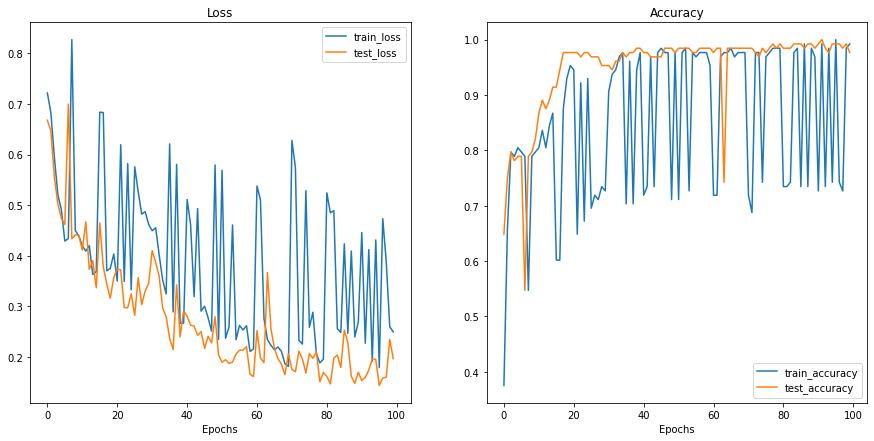

In [14]:
plot_loss_curves(pt_results)